# Use time-travel

To use time-travel in LangGraph:


1. **Run the graph** with initial inputs using `invoke` or `stream` APIs.
2. **Identify a checkpoint in an existing thread**: Use the [`get_state_history()`][langgraph.graph.state.CompiledStateGraph.get_state_history] method to retrieve the execution history for a specific `thread_id` and locate the desired `checkpoint_id`.  
   Alternatively, set a [breakpoint](../../../concepts/breakpoints/) before the node(s) where you want execution to pause. You can then find the most recent checkpoint recorded up to that breakpoint.
3. **(Optional) modify the graph state**: Use the [`update_state`][langgraph.graph.state.CompiledStateGraph.update_state] method to modify the graph’s state at the checkpoint and resume execution from alternative state.
4. **Resume execution from the checkpoint**: Use the `invoke` or `stream` APIs with an input of `None` and a configuration containing the appropriate `thread_id` and `checkpoint_id`.

## Example

This example builds a simple LangGraph workflow that generates a joke topic and writes a joke using an LLM. It demonstrates how to run the graph, retrieve past execution checkpoints, optionally modify the state, and resume execution from a chosen checkpoint to explore alternate outcomes.

### Setup

First we need to install the packages required

In [38]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic

Next, we need to set API keys for Anthropic (the LLM we will use)

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

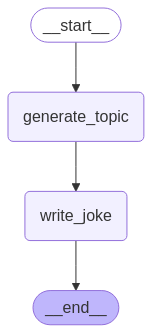

In [2]:
import uuid

from typing_extensions import TypedDict, NotRequired
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver


class State(TypedDict):
    topic: NotRequired[str]
    joke: NotRequired[str]


llm = init_chat_model(
    "anthropic:claude-3-7-sonnet-latest",
    temperature=0,
)


def generate_topic(state: State):
    """LLM call to generate a topic for the joke"""
    msg = llm.invoke("Give me a funny topic for a joke")
    return {"topic": msg.content}


def write_joke(state: State):
    """LLM call to write a joke based on the topic"""
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_topic", generate_topic)
workflow.add_node("write_joke", write_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_topic")
workflow.add_edge("generate_topic", "write_joke")
workflow.add_edge("write_joke", END)

# Compile
checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
graph

### 1. Run the graph

In [3]:
config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
    }
}
state = graph.invoke({}, config)

print(state["topic"])
print()
print(state["joke"])

How about "The Secret Life of Socks in the Dryer"? You know, exploring the mysterious phenomenon of how socks go into the laundry as pairs but come out as singles. Where do they go? Are they starting new lives elsewhere? Is there a sock paradise we don't know about? There's a lot of comedic potential in the everyday mystery that unites us all!

# The Secret Life of Socks in the Dryer

I finally discovered where all my missing socks go after the dryer. Turns out they're not missing at all—they've just eloped with someone else's socks from the laundromat to start new lives together.

My blue argyle is now living in Bermuda with a red polka dot, posting vacation photos on Sockstagram and sending me lint as alimony.


### 2. Identify a checkpoint

In [4]:
# The states are returned in reverse chronological order.
states = list(graph.get_state_history(config))

for state in states:
    print(state.next)
    print(state.config["configurable"]["checkpoint_id"])
    print()

()
1f02ac4a-ec9f-6524-8002-8f7b0bbeed0e

('write_joke',)
1f02ac4a-ce2a-6494-8001-cb2e2d651227

('generate_topic',)
1f02ac4a-a4e0-630d-8000-b73c254ba748

('__start__',)
1f02ac4a-a4dd-665e-bfff-e6c8c44315d9



In [5]:
# This is the state before last (states are listed in chronological order)
selected_state = states[1]
print(selected_state.next)
print(selected_state.values)

('write_joke',)
{'topic': 'How about "The Secret Life of Socks in the Dryer"? You know, exploring the mysterious phenomenon of how socks go into the laundry as pairs but come out as singles. Where do they go? Are they starting new lives elsewhere? Is there a sock paradise we don\'t know about? There\'s a lot of comedic potential in the everyday mystery that unites us all!'}


### 3. Update the state (optional)

`update_state` will create a new checkpoint. The new checkpoint will be associated with the same thread, but a new checkpoint ID.

In [6]:
new_config = graph.update_state(selected_state.config, values={"topic": "chickens"})
print(new_config)

{'configurable': {'thread_id': 'c62e2e03-c27b-4cb6-8cea-ea9bfedae006', 'checkpoint_ns': '', 'checkpoint_id': '1f02ac4a-ecee-600b-8002-a1d21df32e4c'}}


### 4. Resume execution from the checkpoint

In [7]:
graph.invoke(None, new_config)

{'topic': 'chickens',
 'joke': 'Why did the chicken join a band?\n\nBecause it had excellent drumsticks!'}